# HW1: Bayesian Linear Regression


**STATS271/371: Applied Bayesian Statistics**

_Stanford University. Winter, 2021._

---

**Name:** Isaac Kleisle-Murphy

**Names of any collaborators:** Yan, Anmol

*Due: 11:59pm Friday, April 9, 2021 via GradeScope*

---

In this homework assignment you'll perform a Bayesian linear regression. As a quick recap of lecture, we have the following notation:

- Data:
 - $\mathbf{x}_n \in \mathbb{R}^P$ feature/covariates for the $n$-th datapoint
 - $y_n \in \mathbb{R}$ observation for the $n$-th datapoint
- Parameters:
 - $\mathbf{w} \in \mathbb{R}^P$  weights
 - $\sigma^2$ observation/noise variance
- Hyperparameters
 - $\nu, \tau^2$, degrees of freedom and scaling parameter of the inverse chi-squared prior on variance
 - $\boldsymbol{\mu} \in \mathbb{R}^P$ mean vector
 - $\mathbf{\Lambda} \in \mathbb{R}_{\succ 0}^{P \times P}$ positive definite precision matrix

The probabilistic model is as follows,
\begin{align}
p( \{y_n \}_{n=1}^N, \mathbf{w}, \sigma^2 \mid \{\mathbf{x}_n\}_{n=1}^N) 
&= p(\mathbf{w}, \sigma^2) \prod_{n=1}^N p(y_n \mid \mathbf{w}, \sigma^2, \mathbf{x}_n) \\
&= \mathrm{Inv-}\chi^2(\sigma^2 \mid \nu, \tau^2) \, \mathcal{N}(\mathbf{w} \mid \boldsymbol{\mu}, \sigma^2 \mathbf{\Lambda}^{-1}) 
\prod_{n=1}^N \mathcal{N}(y_n \mid \mathbf{w}^\top \mathbf{x}_n, \sigma^2).
\end{align}

Under this model, the posterior distribution $p(\mathbf{w}, \sigma^2 \mid \{y_n, \mathbf{x}_n\}_{n=1}^N)$ is available in closed form, as the prior is conjugate to the likelihood.

Follow the instructions below to compute the posterior distribution and perform the specified analyses. Specifically, we will be performing polynomial regression and recreating plots per the slides of **Lap 1: Bayesian Linear Regression**

In [1]:
# ingest the data
suppressMessages(require(dplyr))
suppressMessages(require(purrr))
suppressMessages(require(ggplot2))
suppressMessages(require(mvtnorm))
options(warn=-1)
FILE_URL = "https://raw.githubusercontent.com/slinderman/stats271sp2021/main/assignments/hw1.csv"

data_raw = read.csv(FILE_URL) %>%
    rename(u=us, y=ys)
data_raw$intcpt = 1
N = nrow(data_raw)
                   
data_raw                

Warning message:
“package ‘dplyr’ was built under R version 3.6.2”
Warning message:
“package ‘purrr’ was built under R version 3.6.2”
Warning message:
“package ‘ggplot2’ was built under R version 3.6.2”


u,y,intcpt
<dbl>,<dbl>,<dbl>
1.7640523,0.9308895,1
0.4001572,0.1471967,1
0.9787380,-0.1238411,1
2.2408932,1.3974271,1
1.8675580,0.4405101,1
-0.9772779,-3.2537728,1
0.9500884,0.2768977,1
-0.1513572,-0.7191391,1
-0.1032189,-1.4743014,1


## Problem 1: Plot the data

Recreate the plot from page 7 of the slides.

Here it is!

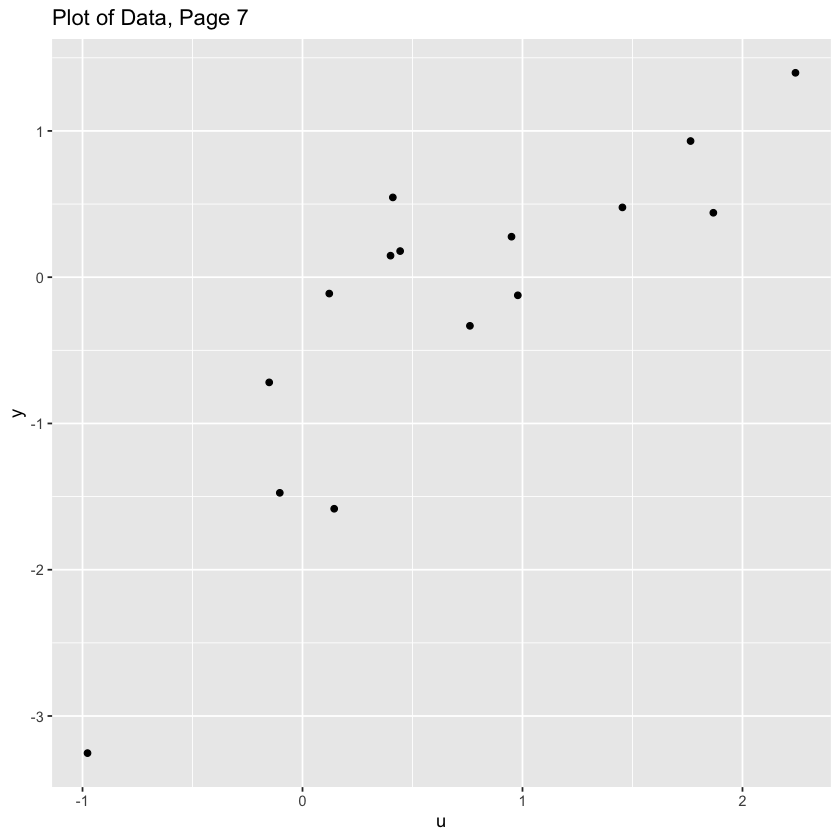

In [2]:
ggplot(data_raw, aes(x=u, y=y))+
    geom_point() + 
    labs(x='u', y='y', title='Plot of Data, Page 7')

## Problem 2: Compute and print the sufficient statistics of the data

Using covariates for a polynomial regression of degree 1 (letting the features $\mathbf{x}_n = (1, u_n)^\top$, calculate and print out the sufficient statistics (per slide 8).

In [3]:
X = data_raw %>% select(intcpt, u) %>% as.matrix() %>% unname()
y = data_raw$y

# sum(y^2)
ss1 = t(y)%*% y 

# lapply(1:N, function(i) X[i, ] * y[i]) %>% do.call("rbind", .) %>% colSums()
ss2 = t(X) %*% y

# easier as matrix
ss3 = t(X) %*% X

cat('Sufficient Stat 1: ', ss1, '\n')
cat('Sufficient Stat 2: ', ss2, '\n')
cat('Sufficient Stat 3: ')
ss3

Sufficient Stat 1:  19.59139 
Sufficient Stat 2:  -3.204591 9.740318 
Sufficient Stat 3: 

15.00000,10.30512
10.30512,17.72586


## Problem 3: Compute and print the posterior parameters $\nu'$, $\tau'^2$, $\boldsymbol{\mu}'$, and $\mathbf{\Lambda}'$

Assume that our prior parameters $\nu = \tau^2 = \boldsymbol{\mu} = \mathbf{\Lambda} = 0$. 

In [4]:
lambda = diag(2) * 0; v = 0; tau_sq = 0; mu = rep(0, 2) 
lambda_prime = lambda + ss3;
v_prime = v + N
mu_prime = solve(lambda_prime) %*% (lambda %*% mu + ss2) # solve(t(X)%*%X) %*% t(X) %*% y
tau_sq_prime = 1/v_prime * (
    v * tau_sq + t(mu) %*% lambda %*% mu + ss1 - t(mu_prime) %*% lambda_prime %*% mu_prime
)

# H = X %*% solve(t(X) %*% X) %*% t(X)
# 1/N * t(y) %*% (diag(N) - H) %*% y

cat("v': ", v_prime, "\n")
cat("u': ", mu_prime, "\n")
cat("t'^2: ", tau_sq_prime, "\n")
cat("Lambda': ")
lambda_prime

v':  15 
u':  -0.9842635 1.12171 
t'^2:  0.3674279 
Lambda': 

15.00000,10.30512
10.30512,17.72586


## Problem 4a: Plot the posterior of $\sigma^2$

(Recreate the plot from slide 25)

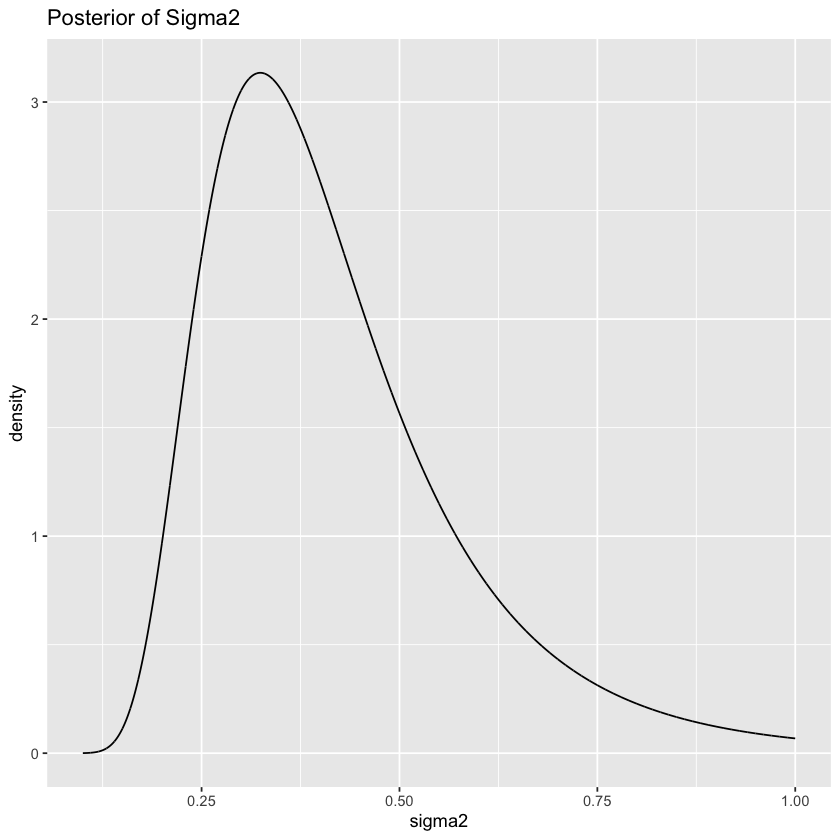

In [5]:
dinvgamma <- function(x, a, b){
    (b^a)/(gamma(a)) * x^(-a - 1) * exp(-b/x)
}

sigma_sq = seq(.1, 1, 1e-4)
p_sigma_sq = dinvgamma(sigma_sq, v_prime/2, v_prime * tau_sq_prime/2)
ggplot(data.frame(sigma2 = sigma_sq, density=p_sigma_sq),
       aes(x=sigma2, y=density)) +
    geom_path() +
    labs(title='Posterior of Sigma2')

## Problem 4b: Plot the posterior of $\mathbf{w}$ for $\sigma^2 \in \{0.2, 0.4, 0.6\}$

(Recreate the figures from slide 26)


$\textit{Assuming that the star is centered at (-1, 1)}$

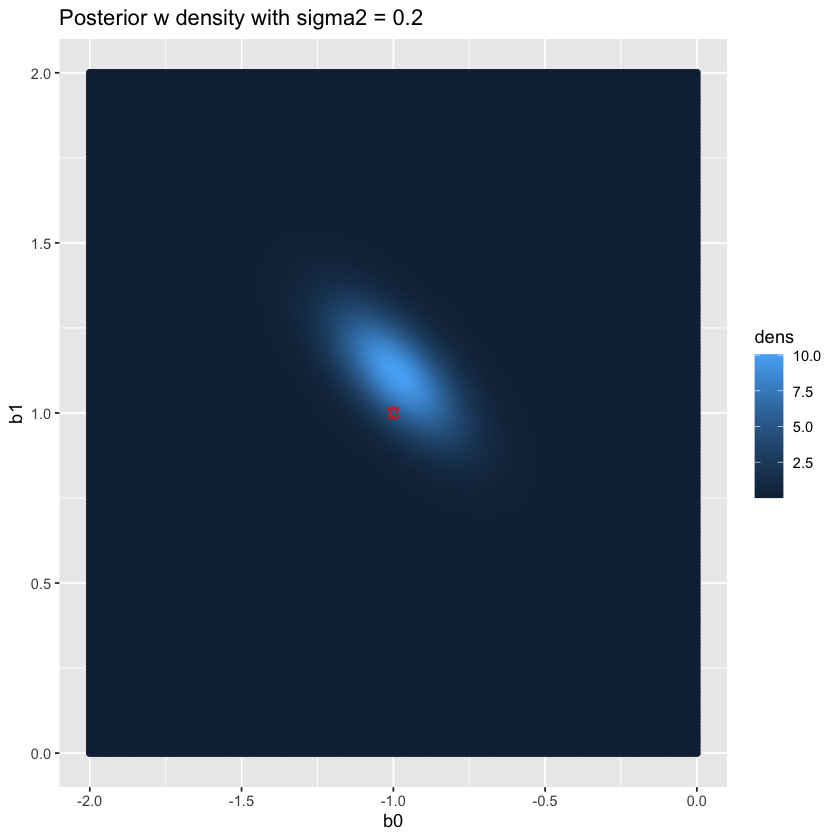

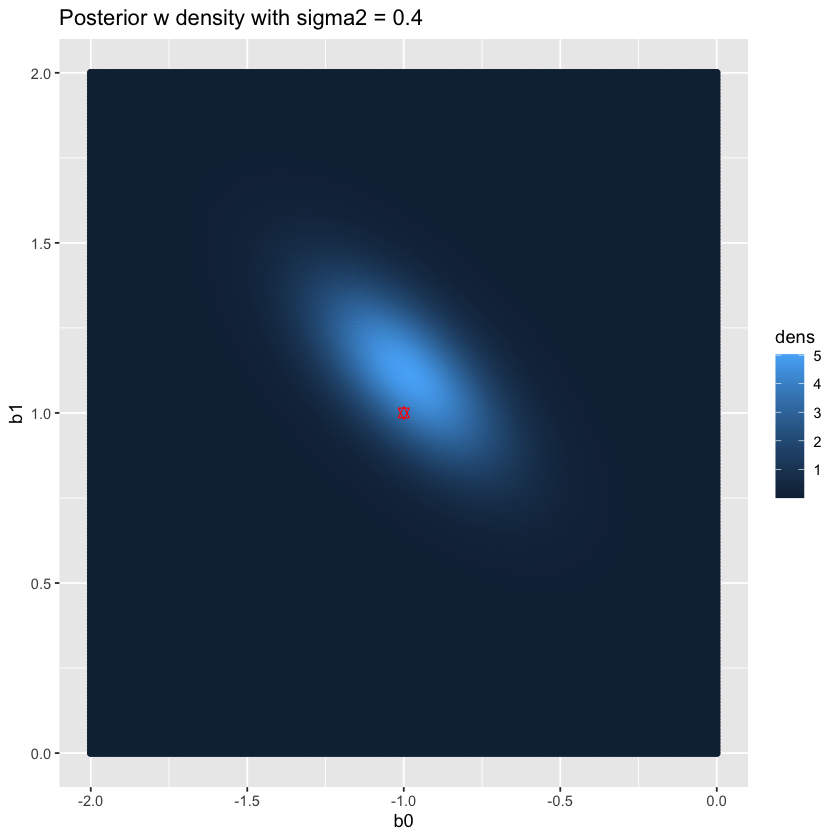

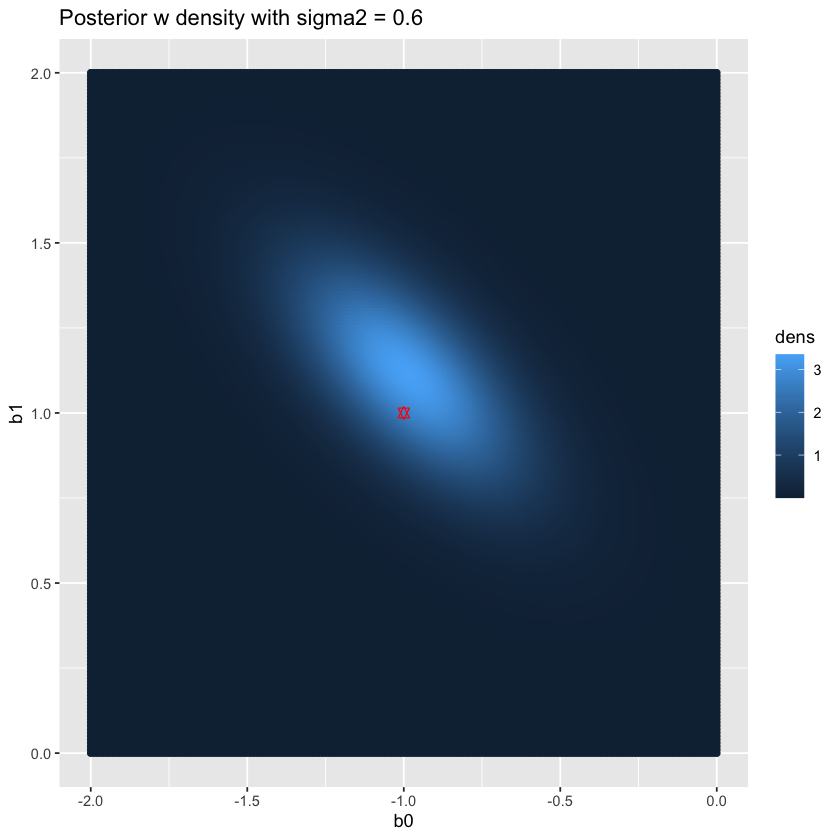

In [6]:
WGRID = expand.grid(b0=seq(-2, 0, .01), b1=seq(0, 2, .01))

plot_weights <- function(sigma2, u=mu_prime, L=lambda_prime, w_grid=WGRID){
    w_grid[, 3] = dmvnorm(w_grid, mu_prime, sigma2 * solve(L))
    w_grid = data.frame(w_grid)
    colnames(w_grid) = c("b0", "b1", "dens")
    plt = ggplot(w_grid, aes(x=b0, y=b1, color=dens)) + geom_point() +
        labs(title=paste0('Posterior w density with sigma2 = ', 
                          as.character(sigma2)))  +
        geom_point(data=data.frame(b0=-1, b1=1), 
                   mapping=aes(x=b0, y=b1), 
                   color="red",
                   shape="star",
                   size=2)
    plt
}


plot_weights(.2)
plot_weights(.4)
plot_weights(.6)

## Problem 5: Compute the log marginal likelihood $p(\{y_n\} | \{\mathbf{x}_n\})$

Compare the log marginal likelihood with covariates $x_n = (u_n^0, \ldots, u_n^{P-1})$ for $P=0,\ldots,4$. Use the following prior parameters:
- $\nu = 0.01$
- $\tau^2 = 0.01$
- $\mathbf{\mu} = (0, \ldots, 0)^\top$
- $\mathbf{\Lambda} = 0.01 I$

To recapitulate the plot (slide 33) from lecture, divide the marginal likelihood by $N$ to get the average log marginal likelihood per datapoint.

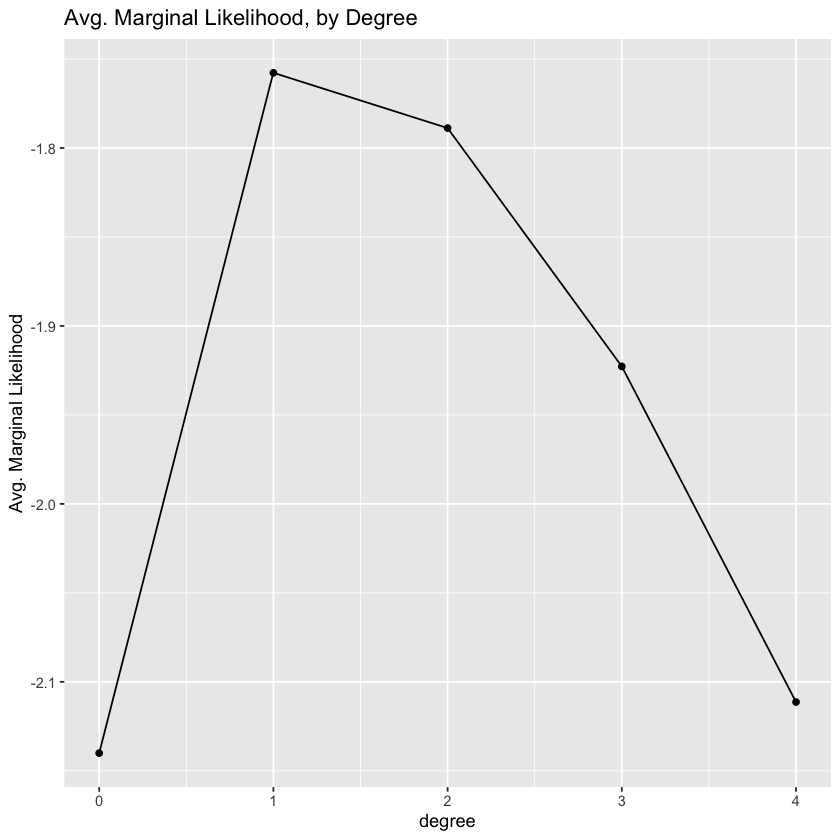

In [7]:
bind_polynomial <- function(df, col, degree=1){
    # expands polynomials
    x_add = lapply(0:degree, function(x) df[, col]^x) %>%
        do.call("cbind", .) %>%
        data.frame() %>%
        `colnames<-`(paste0(col, "_", 0:degree))
    cbind(df, x_add)
}

Z <- function(v, t2, A){
    #' Calculates Z, as set forth on p.17
    nfeat = dim(A)[1]
    (gamma(v/2))/ ((t2 * v/2) ^ (v/2)) *
        (2 * pi)^(nfeat/2) * det(A)^(-1/2)
}

marg_lik <- function(N, v_, t2_, A_, v, t2, A){
    # computes marginal likelihood, from page 30
    (2 * pi) ^ (-N/2) * Z(v_, t2_, A_) / Z(v, t2, A)
}

marginal_liks = c()
for (P in 1:5){
    X = bind_polynomial(data_raw, "u", P-1)[, paste0("u_", 0:(P-1))] %>% as.matrix()
    y = data_raw$y

    ss1 = t(y)%*% y 
    ss2 = t(X) %*% y
    ss3 = t(X) %*% X                   

    lambda = diag(P) * .01; v = 0.01; tau_sq = 0.01; mu = rep(0, P)
    lambda_prime = lambda + ss3;
    v_prime = v + N
    mu_prime = solve(lambda_prime) %*% (lambda %*% mu + ss2) # solve(t(X)%*%X) %*% t(X) %*% y
    tau_sq_prime = 1/v_prime * (
        v * tau_sq + t(mu) %*% lambda %*% mu + ss1 - t(mu_prime) %*% lambda_prime %*% mu_prime
    )
    marginal_liks[P] = log(marg_lik(N, v_prime, tau_sq_prime, lambda_prime, v, tau_sq, lambda))/N
}
                   
ggplot(data.frame(degree = 1:P - 1, marginal_likelihood=marginal_liks),
       aes(x=degree, y=marginal_likelihood)) + 
    geom_point() +
    geom_path() +
    labs(title = "Avg. Marginal Likelihood, by Degree",
         x = "degree",
         y = "Avg. Marginal Likelihood")